In [1]:
#### MAY NEED TO REMOVE --> THESE IMPORTS ARE JUST FOR MY DEPENDENCIES ON MY LOCAL DEVICE
import sys 
sys.path.append('../..')
######

from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import matplotlib.pyplot as plt
import seaborn as sns
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm
from abc import ABC
import IPython
import os
import config

from delphi import train
from delphi import oracle
import delphi.utils.constants as consts
from delphi import grad
# set environment variable so that stores can create output files

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.FloatTensor)
    print("cuda tensors...")
    

# CONSTANTS
EXP_NAME = 'AdamBatch_0.'
SOFTMAX_REGRESSION_STORE_PATH = '/home/gridsan/stefanou/SoftmaxRegression/' + EXP_NAME

# tables
STANDARD_STORE_TABLE = 'standard_table'
TRUNCATED_STORE_TABLE = 'truncated_table'
GUMBEL_CE_TABLE = 'gumbel_table'

STANDARD_EVAL_TABLE = 'standard_eval_table'
TRUNCATED_EVAL_TABLE = 'truncated_eval_table'
GUMBEL_EVAL_TABLE = 'gumbel_eval_table'


TRUNC_TRUTH_TABLE ='truncated_truth_table'
NAIVE_TRUTH_TABLE = 'naive_truth_table'

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Algorithm and Experiment Hyperparameters

In [ ]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 10,
    'num_workers': 8, 
    'batch_size': 64,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'samples': 100000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 10,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': 0,
    'weight_decay': 0,
    'custom_lr_multiplier': consts.CYCLIC,
    'shuffle': True,
    'alpha_thresh': .5,
    'tol': 1e-5,
    'accuracy': True,
    'adam': True, 
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("cuda available...")
else: 
    args.__setattr__('device', 'cpu')
    print("cpu available...")

print("Training Kwargs: ", args)

# Training and Evaluation Procedure Functions

In [3]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1).cpu()
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

# Oracles

In [4]:
lower = oracle.DNN_Lower(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32))
id_ = oracle.Identity()
ball = oracle.DNN_Logit_Ball(ch.full(ch.Size([args.K,]), -1, dtype=ch.float32), ch.full(ch.Size([args.K,]), 1, dtype=ch.float32))

# Experiment

In [5]:
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
            ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices].cpu(), y[indices].cpu()
            alpha = x_trunc.size(0) / X.size(0)
            
        print("alpha: {}".format(alpha))

        # all synthetic data 
        ds = TensorDataset(x_trunc, y_trunc)
        # split ds into training and validation data sets - 80% training, 20% validation
        train_length = int(len(ds)*.8)
        val_length = len(ds) - train_length
        train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
        # train and validation loaders
        train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
        val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

        # test dataset
        x_test = X[~indices].cpu()
        y_test = y[~indices].cpu()
        test_ds = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            
    return ground_truth, (train_loader, val_loader), test_loader

In [6]:
# set truncation oracle
args.__setattr__('phi', id_)
# gradients
gumbel_ce = grad.GumbelCE.apply
logistic_bce = grad.LogisticBCE.apply
trunc_bce = grad.TruncatedBCE.apply
trunc_ce = grad.TruncatedCE.apply

In [ ]:
for lr in [2e-1, 1e-1, 1e-2, 1e-3]: 
    # name store based off of learnign rate and adam
    args.__setattr__('lr', lr)
    store_path = SOFTMAX_REGRESSION_STORE_PATH + '_' + str(lr)

    # perform number of trials experiments
    for i in range(args.trials):
        out_store = Store(store_path)
        # create store
        trunc_epoch_hook = epoch_hook(out_store, table_name=TRUNC_TRUTH_TABLE)
        naive_epoch_hook = epoch_hook(out_store, table_name=NAIVE_TRUTH_TABLE)

        # determine exp completion based off of score
        args.__setattr__('score', True)
        # generate data for exp
        ground_truth, loaders, test_loader = gen_data()
        # set ground-truth
        trunc_epoch_hook.set_ground_truth(ground_truth)
        args.__setattr__('epoch_hook', trunc_epoch_hook)

        # new classifier models at the beginning of each trial
        trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

        args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
        config.args = args # set global args
        train.train_model(args, trunc_multi_log_reg, loaders, store=out_store, table=TRUNCATED_STORE_TABLE)

        # set ground-truth
        naive_epoch_hook.set_ground_truth(ground_truth)
        args.__setattr__('epoch_hook', naive_epoch_hook)

        # new classifier models at the beginning of each trial
        standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

        # naive ce loss
        args.__setattr__('custom_criterion', ch.nn.CrossEntropyLoss()) # default ce loss
        config.args = args # set global args
        train.train_model(args, standard_multi_log_reg, loaders, store=out_store, 
                    table=STANDARD_STORE_TABLE)

        # standard multinomial logistic regression eval - if there is a test set
        if len(test_loader) > 0:
            args.__setattr__('score', False)
            # truncated multinomial logistic regression eval
            config.args = args # set global args
            train.eval_model(args, trunc_multi_log_reg, test_loader, out_store, table=TRUNCATED_EVAL_TABLE)

            # standard multinomial logistic regression eval
            config.args = args # set global args
            train.eval_model(args, standard_multi_log_reg, test_loader, out_store, table=STANDARD_EVAL_TABLE)

        IPython.display.clear_output(wait=False)


        # close store after experiment
        out_store.close()

Logging in: /home/gridsan/stefanou/SoftmaxRegression/Adam_0.001/6fb1b482-99f0-4c5a-938e-88f316942bbd
alpha: 1.0


# Plot Results

100%|██████████| 10/10 [00:00<00:00, 41.70it/s]


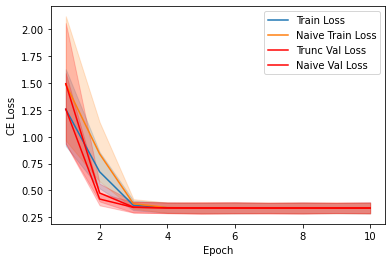

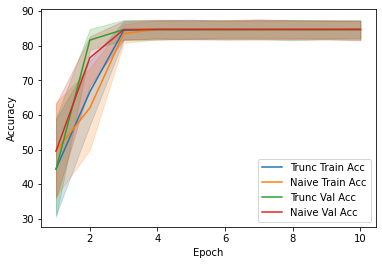

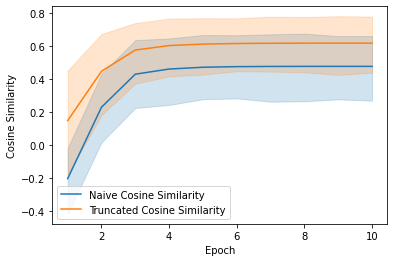

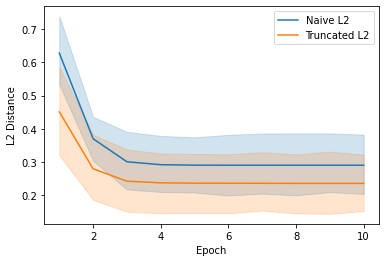

Standard Test Accuracy: 0    80.003998
0    89.941002
0    90.986000
0    84.627998
0    87.738998
0    84.528999
0    76.418999
0    84.647003
0    87.385002
0    81.280998
Name: test_prec1, dtype: float64
Truncated Test Accuracy: 0    80.004997
0    89.945000
0    90.990997
0    84.632004
0    87.737999
0    84.528000
0    76.419998
0    84.651001
0    87.383003
0    81.276001
Name: test_prec1, dtype: float64


In [12]:
# read results form 
reader = CollectionReader(SOFTMAX_REGRESSION_STORE_PATH + '001')

# TRUNCATED CE LOSS DATA
trunc_logs = reader.df(TRUNCATED_STORE_TABLE)
trunc_truth_table = reader.df(TRUNC_TRUTH_TABLE)
# STANDARD CE LOSS DATA
standard_logs = reader.df(STANDARD_STORE_TABLE)
standard_truth_table = reader.df(NAIVE_TRUTH_TABLE)

sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
ax.set(xlabel='Epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=standard_truth_table, x='epoch', y='cos_sim', label='Naive Cosine Similarity')
ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='cos_sim', label='Truncated Cosine Similarity')
ax.set(xlabel='Epoch', ylabel='Cosine Similarity')
plt.show()

sns.lineplot(data=standard_truth_table, x='epoch', y='l2', label='Naive L2')
ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='l2', label='Truncated L2')
ax.set(xlabel='Epoch', ylabel='L2 Distance')
plt.show()

try: 
    # STANDARD TEST SET RESULTS 
    standard_test_results = reader.df(STANDARD_EVAL_TABLE)

    # TRUNCATED TEST SET RESULTS 
    trunc_test_results = reader.df(TRUNCATED_EVAL_TABLE)

    print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
    print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))
except: 
    print("No Test Results to Report")

reader.close() # close reader

In [8]:
from torch.optim import SGD

In [11]:
opt = SGD(ch.nn.Linear(in_features=2, out_features=1).parameters(), lr=1e-1)

In [13]:
opt.param_groups[0]['lr']

[{'params': [Parameter containing:
   tensor([[0.6040, 0.5480]], requires_grad=True),
   Parameter containing:
   tensor([0.3807], requires_grad=True)],
  'lr': 0.1,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

In [10]:
weight_grad = Tensor([-0.1491,  0.1493])

In [11]:
weight_grad / weight_grad.norm()

tensor([-0.7066,  0.7076])